In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [ ]:
import os
os._exit(00)

In [1]:
!pip install --upgrade google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.19.0
    Uninstalling google-cloud-storage-2.19.0:
      Successfully uninstalled google-cloud-storage-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.79.0 requires google-cloud-storage<3.0.0dev,>=1.32.0, but you have google-cloud-storage 3.1.0 which is incompatible.


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00


In [2]:
import gc

### Machine possibilities research:

In [ ]:
!nvidia-smi

Thu Mar  6 14:45:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
batch_size = 1
while True:
    try:
        x = torch.randn(batch_size, 1, 16000).to("cuda")
        batch_size *= 2
    except RuntimeError:
        print(f"Max batch size before OOM: {batch_size // 2}")
        break

KeyboardInterrupt: 

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

8


### Dataset loading

In [3]:
from google.colab import auth

In [4]:
auth.authenticate_user()

In [5]:
!gcloud auth login --quiet

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=dljQfpBX9KlvVJF6VOlw80Rvb6wCOn&prompt=consent&token_usage=remote&access_type=offline&code_challenge=c5b-RAG-Dj50wfGll_boSw6Vo2m-QXqVibZHXOYO5x4&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AQSTgQEDWMEnlTRy8LXYKsaj50VmQoQgD4ioiHl_LC9HnKT8Qa27n71krnp7LhI-bnVDAQ

You are now logged in as [khrystyna.dol.3@gmail.com].
Your current proj

In [6]:
!gcloud config set project ser-diploma

Updated property [core/project].


### Dataset processing:

In [ ]:
from google.cloud import storage

client = storage.Client()
bucket_name = "mc-eiu-data"

bucket = client.bucket(bucket_name)
blobs = bucket.list_blobs()

for blob in blobs:
    print(blob.name)
    break

del bucket, blobs
gc.collect()

EnglishDialogues.csv


0

In [ ]:
import os
import pandas as pd
from google.cloud import storage

BUCKET_NAME = "mc-eiu-data"
CSV_FILE_PATH = f"EnglishDialogues.csv"
AUDIO_FOLDER_PATH = "MC-EIU-audio/"
LOCAL_AUDIO_DIR = "/content/mc-eiu-data/"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

blob = bucket.blob(CSV_FILE_PATH)
csv_content = blob.download_as_text()
df = pd.read_csv(pd.io.common.StringIO(csv_content))

def get_audio_filename(dia, utt):
    return f"dia_{dia}_utt_{utt}.mp3"

def file_exists_in_bucket(filename):
    return storage.Blob(bucket=bucket, name=f"{AUDIO_FOLDER_PATH}{filename}").exists(storage_client)

dataset = []
idx = 0
for _, row in df.iterrows():
    audio_filename = get_audio_filename(row["Dia_No"], row["Utt_No"])

    if file_exists_in_bucket(audio_filename):
        dataset.append({
            "audio_file": f"gs://{BUCKET_NAME}/{AUDIO_FOLDER_PATH}{audio_filename}",
            "audio_file_local": f"{LOCAL_AUDIO_DIR}{audio_filename}",
            "text": row["Script"],
            "emotion": row["emotion"],
            "intent": row["intent"],
            "speaker": row["speaker"],
            "dialogue_id": row["Dia_No"],
            "utterance_id": row["Utt_No"]
        })
    if idx % 1000 == 0:
      print("Files processed", idx)
    idx += 1

dataset_df = pd.DataFrame(dataset)

print(f"Loaded dataset with {len(dataset_df)} matched samples.")
dataset_df.head()

Files processed 0
Files processed 1000
Files processed 2000
Files processed 3000
Files processed 4000
Files processed 5000
Files processed 6000
Files processed 7000
Files processed 8000
Files processed 9000
Files processed 10000
Files processed 11000
Files processed 12000
Files processed 13000
Files processed 14000
Files processed 15000
Files processed 16000
Files processed 17000
Files processed 18000
Files processed 19000
Files processed 20000
Files processed 21000
Files processed 22000
Files processed 23000
Files processed 24000
Files processed 25000
Files processed 26000
Files processed 27000
Files processed 28000
Files processed 29000
Files processed 30000
Files processed 31000
Files processed 32000
Files processed 33000
Files processed 34000
Files processed 35000
Files processed 36000
Files processed 37000
Files processed 38000
Files processed 39000
Files processed 40000
Files processed 41000
Files processed 42000
Files processed 43000
Files processed 44000
Files processed 45000
L

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4


In [ ]:
dataset_df["emotion"].value_counts()

,count
emotion,
neutral,21428
happy,12622
anger,4476
sad,2649
surprise,1732
fear,1256
disgust,844


In [ ]:
dataset_df["intent"].value_counts()

,count
intent,
neutral,17767
questioning,10131
suggesting,4748
consoling,4009
agreeing,2997
wishing,2714
encouraging,1792
acknowledging,584
sympathizing,265


In [ ]:
emotion_to_label = {
    "neutral": 0, "happy": 1, "anger": 2, "sad": 3,
    "surprise": 4, "fear": 5, "disgust": 6
}

dataset_df["emotion_label"] = dataset_df["emotion"].map(emotion_to_label).fillna(-1).astype(int)
dataset_df.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1,0
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2,0
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3,2
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4,0


In [ ]:
dataset_df["emotion_label"].value_counts()

,count
emotion_label,
0,21428
1,12622
2,4476
3,2649
4,1732
5,1256
6,844


In [ ]:
local_csv_path = "/content/processed_dataset_local.csv"
dataset_df.to_csv(local_csv_path, index=False)
print(f"Saved locally at: {local_csv_path}")

OUTPUT_CSV_PATH = "MC-EIU-processed_local.csv"

output_blob = bucket.blob(OUTPUT_CSV_PATH)
output_blob.upload_from_filename(local_csv_path)
print(f"Uploaded to GCS: gs://{BUCKET_NAME}/{OUTPUT_CSV_PATH}")

Saved locally at: /content/processed_dataset_local.csv
Uploaded to GCS: gs://mc-eiu-data/MC-EIU-processed_local.csv


### Loading dataset from gcp bucket:

In [15]:
import pandas as pd
import gcsfs

fs = gcsfs.GCSFileSystem(project='ser-diploma')
gcs_path = 'gs://mc-eiu-data/MC-EIU-processed_local.csv'

with fs.open(gcs_path, 'r') as f:
    df = pd.read_csv(f)

df.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1,0
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2,0
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3,2
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4,0


In [8]:
df = df[['audio_file_local', 'emotion_label']].copy()
df.head()

,audio_file_local,emotion_label
0,/content/mc-eiu-data/dia_1_utt_0.mp3,1
1,/content/mc-eiu-data/dia_1_utt_1.mp3,0
2,/content/mc-eiu-data/dia_1_utt_2.mp3,0
3,/content/mc-eiu-data/dia_1_utt_3.mp3,2
4,/content/mc-eiu-data/dia_1_utt_4.mp3,0


### Loading data:

In [16]:
# train_ratio = 0.8
# dataset_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
# split_idx = int(len(dataset_shuffled) * train_ratio)

# train_dataset = dataset_shuffled[:split_idx]
# test_dataset = dataset_shuffled[split_idx:]

# print(f"Train set: {len(train_dataset)} samples, Test set: {len(test_dataset)} samples")

train_ratio = 0.7
val_ratio = 0.15

dataset_reduced = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
dataset_shuffled = dataset_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

train_idx = int(len(dataset_shuffled) * train_ratio)
val_idx = int(len(dataset_shuffled) * (train_ratio + val_ratio))

train_dataset = dataset_shuffled[:train_idx]
val_dataset = dataset_shuffled[train_idx:val_idx]
test_dataset = dataset_shuffled[val_idx:]

print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Train set: 3150 samples
Validation set: 675 samples
Test set: 676 samples


In [10]:
del df
gc.collect()

92

In [43]:
train_dataset["emotion_label"].value_counts(normalize=True) * 100

,proportion
emotion_label,
0,46.317460
1,29.365079
2,10.603175
3,5.079365
4,3.460317
5,3.047619
6,2.126984


In [ ]:
test_dataset["emotion_label"].value_counts(normalize=True) * 100

,proportion
emotion_label,
0,48.400474
1,27.458531
2,9.789692
3,5.716825
4,3.954384
5,2.769550
6,1.910545


### Processing data on disk:

In [17]:
import os
import concurrent.futures
from google.cloud import storage

GCS_BUCKET_NAME = "mc-eiu-data"
LOCAL_AUDIO_DIR = "/content/mc-eiu-data"

os.makedirs(LOCAL_AUDIO_DIR, exist_ok=True)

storage_client = storage.Client()
bucket = storage_client.bucket(GCS_BUCKET_NAME)

def download_audio_from_gcs(gcs_path):
    """Downloads a single file from GCS to local disk (only if not already downloaded)."""
    filename = os.path.basename(gcs_path)
    local_path = os.path.join(LOCAL_AUDIO_DIR, filename)

    if os.path.exists(local_path):
        return local_path

    blob = bucket.blob(gcs_path.replace(f"gs://{GCS_BUCKET_NAME}/", ""))
    blob.download_to_filename(local_path)
    return local_path

def download_files_parallel(dataset):
    """Downloads all audio files in parallel for a given dataset."""
    gcs_paths = dataset["audio_file"].tolist()

    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        local_paths = list(executor.map(download_audio_from_gcs, gcs_paths))

    # dataset["audio_file_local_path"] = local_paths
    # dataset.loc[:, "audio_file_local_path"] = local_paths

In [18]:
for dataset in [train_dataset, val_dataset, test_dataset]:
    download_files_parallel(dataset)

print("All files downloaded to:", LOCAL_AUDIO_DIR)

All files downloaded to: /content/mc-eiu-data


In [19]:
!ls -l /content/mc-eiu-data | wc -l

4502


In [19]:
train_dataset.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_3092_utt_15.mp3,/content/mc-eiu-data/dia_3092_utt_15.mp3,-,happy,agreeing,1,3092,15,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_4021_utt_6.mp3,/content/mc-eiu-data/dia_4021_utt_6.mp3,-,happy,neutral,1,4021,6,1
2,gs://mc-eiu-data/MC-EIU-audio/dia_606_utt_3.mp3,/content/mc-eiu-data/dia_606_utt_3.mp3,Phoebe: Yeah! And until then you are going to ...,happy,neutral,1,606,3,1
3,gs://mc-eiu-data/MC-EIU-audio/dia_3298_utt_6.mp3,/content/mc-eiu-data/dia_3298_utt_6.mp3,-,surprise,neutral,0,3298,6,4
4,gs://mc-eiu-data/MC-EIU-audio/dia_2279_utt_0.mp3,/content/mc-eiu-data/dia_2279_utt_0.mp3,Manny : Are you sure this is teal? 'Cause I'm ...,neutral,questioning,0,2279,0,0


In [20]:
train_dataset = train_dataset[['audio_file_local', 'emotion_label']].copy()
# train_dataset.head()

val_dataset = val_dataset[['audio_file_local', 'emotion_label']].copy()
test_dataset = test_dataset[['audio_file_local', 'emotion_label']].copy()

In [ ]:
import os

local_audio_dir = "/content/mc-eiu-data"
dataset_files = set(os.listdir(local_audio_dir))

for dataset in [train_dataset, val_dataset, test_dataset]:
    missing_files = [path for path in dataset["audio_file_local_path"] if os.path.basename(path) not in dataset_files]

    if missing_files:
        print(f"Missing or corrupted files: {len(missing_files)}")
        print(missing_files[:5])

In [ ]:
import librosa

def safe_load_audio(file_path, sr=8000):
    if not os.path.exists(file_path):
        print(f"Warning: Missing file {file_path}, skipping.")
        return None, None

    try:
        speech, _ = librosa.load(file_path, sr=sr, mono=True)
        return speech, _
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

speech, _ = safe_load_audio("/content/mc-eiu-data/dia_1901_utt_1.mp3")

Error loading /content/mc-eiu-data/dia_1901_utt_1.mp3: 


<ipython-input-29-25dc94342aae>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, _ = librosa.load(file_path, sr=sr, mono=True)


### Model setup and training 1:

In [21]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["audio_file_local"], sr=16000, mono=True)
    example["speech"] = speech
    return example

In [22]:
train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
test_data = Dataset.from_pandas(test_dataset).map(map_to_array)

Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

Map:   0%|          | 0/675 [00:00<?, ? examples/s]

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

In [23]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [24]:
train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

In [25]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        # self.pattern = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}
        self.pattern = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
        # pattern = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
        # self.labels = [pattern[x] for x in labels]
        self.labels = [self.pattern.get(x) for x in labels]
        # self.labels = [self.pattern.get(x, -1) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        label = self.labels[idx]
        if label == -1:
            raise ValueError(f"Invalid label at index {idx}: Original label {self.labels[idx]}, this: {label}")
        item['emotion_label'] = torch.tensor(label)
        return item

    # def __getitem__(self, idx):
    #     item = {key: val[idx] for key, val in self.encodings.items()}
    #     item['emotion_label'] = torch.tensor(self.labels[idx])
    #     return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
val_dataset = CustomDataset(val_encodings, list(val_data["emotion_label"]))
test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))

In [50]:
print(train_dataset)

                              audio_file_local  emotion_label
0     /content/mc-eiu-data/dia_3092_utt_15.mp3              1
1      /content/mc-eiu-data/dia_4021_utt_6.mp3              1
2       /content/mc-eiu-data/dia_606_utt_3.mp3              1
3      /content/mc-eiu-data/dia_3298_utt_6.mp3              4
4      /content/mc-eiu-data/dia_2279_utt_0.mp3              0
...                                        ...            ...
3145   /content/mc-eiu-data/dia_1341_utt_0.mp3              0
3146   /content/mc-eiu-data/dia_2012_utt_8.mp3              5
3147    /content/mc-eiu-data/dia_373_utt_0.mp3              6
3148   /content/mc-eiu-data/dia_3103_utt_3.mp3              2
3149   /content/mc-eiu-data/dia_3866_utt_5.mp3              1

[3150 rows x 2 columns]


In [26]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.gradient_checkpointing_enable()
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [59]:
print(train_dataset.labels)

[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 4, 4, 2, 0, 0, 1, 1, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0, 1, 5, 0, 1, 0, 0, 1, 0, 1, 5, 0, 2, 1, 0, 0, 0, 6, 0, 0, 0, 0, 1, 1, 1, 3, 1, 4, 1, 0, 0, 1, 0, 6, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 1, 0, 0, 0, 1, 1, 6, 1, 1, 0, 0, 0, 1, 3, 2, 1, 0, 0, 5, 1, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 0, 4, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 5, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 5, 0, 2, 1, 1, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0, 0, 6, 1, 0, 0, 2, 6, 0, 0, 5, 1, 0, 3, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 5, 1, 0, 3, 0, 0, 0, 4, 0, 1, 0, 0, 2, 3, 4, 0, 4, 1, 0, 0, 0, 3, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 2, 0, 1, 0, 0, 1, 0, 0, 3, 0, 1, 3, 0, 1, 0, 1, 0, 0, 4, 0, 0, 4, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 6, 3, 1, 2, 1, 5, 0, 1, 1, 0, 1, 1, 1, 3, 0, 0, 1, 0, 0, 5, 0, 3, 1, 0, 0, 0, 0, 4, 1, 2, 6, 6, 0, 0, 0, 6, 1, 

In [46]:
len(train_dataset)

3150

In [66]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [28]:
print(set(train_data["emotion_label"]))

{0, 1, 2, 3, 4, 5, 6}


In [31]:
import torch
import time
from tqdm import tqdm
from torch.utils.data import DataLoader

epoch = 4
model.train()

train_loss = []
train_accuracies = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=False)

    correct = 0
    count = 0
    epoch_loss = []

    pbar = tqdm(train_loader)

    for i, batch in enumerate(pbar):
        optim.zero_grad()

        input_ids = batch['input_values'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['emotion_label'].to(device, non_blocking=True)

        if i % 50 == 0:
            print(f"GPU Memory Usage Before Forward: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        loss.backward()
        optim.step()

        if i % 50 == 0:
            print(f"GPU Memory Usage After Backward: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

        with torch.no_grad():
            predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Accuracy': f'{accuracy:.3f}'
        })

        epoch_loss.append(loss.item())

        # del input_ids, attention_mask, labels, outputs, loss
        # torch.cuda.empty_cache()

    if epoch_i == 0 or accuracy > max(train_accuracies):
        torch.save(model.state_dict(), f"mc-eiu-hubert-model.pth")

    pbar.close()

    train_loss.extend(epoch_loss)
    train_accuracies.append(accuracy)

    torch.cuda.empty_cache()
    time.sleep(1)

Epoch 1/4


  0%|          | 0/1575 [00:00<?, ?it/s]

GPU Memory Usage Before Forward: 3.825 GB
GPU Memory Usage After Backward: 5.257 GB


  3%|▎         | 50/1575 [03:27<1:46:55,  4.21s/it, Loss=0.747, Accuracy=0.490]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.125 GB


  6%|▋         | 100/1575 [06:50<1:37:36,  3.97s/it, Loss=3.019, Accuracy=0.515]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.382 GB


 10%|▉         | 150/1575 [10:17<1:37:44,  4.12s/it, Loss=0.896, Accuracy=0.503]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.254 GB


 13%|█▎        | 200/1575 [13:45<1:36:24,  4.21s/it, Loss=0.825, Accuracy=0.530]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.125 GB


 16%|█▌        | 250/1575 [17:11<1:28:54,  4.03s/it, Loss=1.942, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.059 GB


 19%|█▉        | 300/1575 [20:37<1:27:02,  4.10s/it, Loss=0.344, Accuracy=0.527]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.384 GB


 22%|██▏       | 350/1575 [24:05<1:25:06,  4.17s/it, Loss=3.872, Accuracy=0.523]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.384 GB


 25%|██▌       | 400/1575 [27:33<1:24:05,  4.29s/it, Loss=1.256, Accuracy=0.521]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.319 GB


 29%|██▊       | 450/1575 [31:02<1:16:23,  4.07s/it, Loss=0.917, Accuracy=0.510]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.250 GB


 32%|███▏      | 500/1575 [34:30<1:14:00,  4.13s/it, Loss=2.608, Accuracy=0.512]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.267 GB


 35%|███▍      | 550/1575 [37:56<1:11:10,  4.17s/it, Loss=0.233, Accuracy=0.519]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.123 GB


 38%|███▊      | 600/1575 [41:23<1:08:29,  4.22s/it, Loss=3.247, Accuracy=0.520]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.255 GB


 41%|████▏     | 650/1575 [44:50<1:02:27,  4.05s/it, Loss=0.784, Accuracy=0.520]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.313 GB


 44%|████▍     | 700/1575 [48:15<1:01:34,  4.22s/it, Loss=2.829, Accuracy=0.522]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.254 GB


 48%|████▊     | 750/1575 [51:42<55:18,  4.02s/it, Loss=0.631, Accuracy=0.521]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.318 GB


 51%|█████     | 800/1575 [55:10<53:43,  4.16s/it, Loss=2.567, Accuracy=0.522]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.382 GB


 54%|█████▍    | 850/1575 [58:37<50:32,  4.18s/it, Loss=1.360, Accuracy=0.518]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.448 GB


 57%|█████▋    | 900/1575 [1:02:03<47:00,  4.18s/it, Loss=1.097, Accuracy=0.517]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.382 GB


 60%|██████    | 950/1575 [1:05:32<44:30,  4.27s/it, Loss=1.316, Accuracy=0.517]

GPU Memory Usage Before Forward: 4.184 GB
GPU Memory Usage After Backward: 5.250 GB


 63%|██████▎   | 1000/1575 [1:08:59<39:50,  4.16s/it, Loss=0.468, Accuracy=0.514]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.317 GB


 67%|██████▋   | 1050/1575 [1:12:25<35:28,  4.06s/it, Loss=0.882, Accuracy=0.515]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.192 GB


 70%|██████▉   | 1100/1575 [1:15:50<32:37,  4.12s/it, Loss=1.027, Accuracy=0.513]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.251 GB


 73%|███████▎  | 1150/1575 [1:19:15<28:10,  3.98s/it, Loss=1.640, Accuracy=0.512]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.382 GB


 76%|███████▌  | 1200/1575 [1:22:41<25:36,  4.10s/it, Loss=1.526, Accuracy=0.512]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.252 GB


 79%|███████▉  | 1250/1575 [1:26:07<22:04,  4.07s/it, Loss=1.597, Accuracy=0.510]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.445 GB


 83%|████████▎ | 1300/1575 [1:29:33<19:18,  4.21s/it, Loss=1.754, Accuracy=0.507]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.252 GB


 86%|████████▌ | 1350/1575 [1:33:01<15:12,  4.06s/it, Loss=0.751, Accuracy=0.504]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.381 GB


 89%|████████▉ | 1400/1575 [1:36:27<12:28,  4.28s/it, Loss=0.971, Accuracy=0.506]

GPU Memory Usage Before Forward: 4.183 GB
GPU Memory Usage After Backward: 5.203 GB


 92%|█████████▏| 1450/1575 [1:39:53<08:46,  4.21s/it, Loss=1.466, Accuracy=0.506]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.381 GB


 95%|█████████▌| 1500/1575 [1:43:19<05:09,  4.12s/it, Loss=1.206, Accuracy=0.507]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.191 GB


 98%|█████████▊| 1550/1575 [1:46:44<01:41,  4.04s/it, Loss=2.717, Accuracy=0.509]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.381 GB


100%|██████████| 1575/1575 [1:48:28<00:00,  4.13s/it, Loss=2.127, Accuracy=0.509]


Epoch 2/4


  0%|          | 0/1575 [00:00<?, ?it/s]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.255 GB


  3%|▎         | 50/1575 [03:24<1:39:31,  3.92s/it, Loss=2.494, Accuracy=0.560]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.317 GB


  6%|▋         | 100/1575 [06:50<1:44:57,  4.27s/it, Loss=0.378, Accuracy=0.555]

GPU Memory Usage Before Forward: 4.183 GB
GPU Memory Usage After Backward: 5.192 GB


 10%|▉         | 150/1575 [10:15<1:39:29,  4.19s/it, Loss=0.618, Accuracy=0.553]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.254 GB


 13%|█▎        | 200/1575 [13:40<1:29:58,  3.93s/it, Loss=0.657, Accuracy=0.535]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.254 GB


 16%|█▌        | 250/1575 [17:07<1:29:55,  4.07s/it, Loss=0.917, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.382 GB


 19%|█▉        | 300/1575 [20:34<1:29:36,  4.22s/it, Loss=0.744, Accuracy=0.538]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.333 GB


 22%|██▏       | 350/1575 [23:59<1:25:27,  4.19s/it, Loss=0.170, Accuracy=0.549]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.316 GB


 25%|██▌       | 400/1575 [27:27<1:19:08,  4.04s/it, Loss=0.537, Accuracy=0.544]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.317 GB


 29%|██▊       | 450/1575 [30:54<1:17:40,  4.14s/it, Loss=2.264, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.446 GB


 32%|███▏      | 500/1575 [34:21<1:14:55,  4.18s/it, Loss=0.729, Accuracy=0.536]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.384 GB


 35%|███▍      | 550/1575 [37:50<1:10:15,  4.11s/it, Loss=0.979, Accuracy=0.539]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.253 GB


 38%|███▊      | 600/1575 [41:13<1:06:21,  4.08s/it, Loss=0.717, Accuracy=0.542]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.318 GB


 41%|████▏     | 650/1575 [44:42<1:02:30,  4.05s/it, Loss=0.778, Accuracy=0.536]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.322 GB


 44%|████▍     | 700/1575 [48:10<59:46,  4.10s/it, Loss=2.057, Accuracy=0.543]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.190 GB


 48%|████▊     | 750/1575 [51:38<56:44,  4.13s/it, Loss=1.711, Accuracy=0.539]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.320 GB


 51%|█████     | 800/1575 [55:06<55:13,  4.28s/it, Loss=0.386, Accuracy=0.544]

GPU Memory Usage Before Forward: 4.183 GB
GPU Memory Usage After Backward: 5.448 GB


 54%|█████▍    | 850/1575 [58:33<51:36,  4.27s/it, Loss=0.234, Accuracy=0.538]

GPU Memory Usage Before Forward: 4.184 GB
GPU Memory Usage After Backward: 5.319 GB


 57%|█████▋    | 900/1575 [1:01:57<46:34,  4.14s/it, Loss=1.078, Accuracy=0.535]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.203 GB


 60%|██████    | 950/1575 [1:05:24<43:05,  4.14s/it, Loss=1.982, Accuracy=0.534]

GPU Memory Usage Before Forward: 4.183 GB
GPU Memory Usage After Backward: 5.318 GB


 63%|██████▎   | 1000/1575 [1:08:51<40:03,  4.18s/it, Loss=2.192, Accuracy=0.537]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.255 GB


 67%|██████▋   | 1050/1575 [1:12:16<36:05,  4.12s/it, Loss=1.088, Accuracy=0.538]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.127 GB


 70%|██████▉   | 1100/1575 [1:15:43<32:59,  4.17s/it, Loss=1.064, Accuracy=0.539]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.383 GB


 73%|███████▎  | 1150/1575 [1:19:08<29:46,  4.20s/it, Loss=0.903, Accuracy=0.537]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.317 GB


 76%|███████▌  | 1200/1575 [1:22:35<26:05,  4.18s/it, Loss=0.961, Accuracy=0.536]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.317 GB


 79%|███████▉  | 1250/1575 [1:26:02<22:41,  4.19s/it, Loss=0.695, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.385 GB


 83%|████████▎ | 1300/1575 [1:29:30<18:34,  4.05s/it, Loss=0.891, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.124 GB


 86%|████████▌ | 1350/1575 [1:32:54<14:53,  3.97s/it, Loss=1.235, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.320 GB


 89%|████████▉ | 1400/1575 [1:36:20<11:50,  4.06s/it, Loss=1.002, Accuracy=0.530]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.252 GB


 92%|█████████▏| 1450/1575 [1:39:47<08:42,  4.18s/it, Loss=1.932, Accuracy=0.527]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.384 GB


 95%|█████████▌| 1500/1575 [1:43:14<05:16,  4.22s/it, Loss=2.702, Accuracy=0.526]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.381 GB


 98%|█████████▊| 1550/1575 [1:46:40<01:40,  4.03s/it, Loss=2.873, Accuracy=0.525]

GPU Memory Usage Before Forward: 4.101 GB
GPU Memory Usage After Backward: 5.252 GB


100%|██████████| 1575/1575 [1:48:24<00:00,  4.13s/it, Loss=0.867, Accuracy=0.526]


Epoch 3/4


  0%|          | 0/1575 [00:00<?, ?it/s]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.445 GB


  3%|▎         | 50/1575 [03:26<1:46:27,  4.19s/it, Loss=0.514, Accuracy=0.600]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.318 GB


  6%|▋         | 100/1575 [06:53<1:38:25,  4.00s/it, Loss=0.835, Accuracy=0.560]

GPU Memory Usage Before Forward: 4.115 GB
GPU Memory Usage After Backward: 5.251 GB


 10%|▉         | 150/1575 [10:21<1:39:10,  4.18s/it, Loss=1.271, Accuracy=0.547]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.317 GB


 13%|█▎        | 200/1575 [13:49<1:37:43,  4.26s/it, Loss=1.214, Accuracy=0.555]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.379 GB


 16%|█▌        | 250/1575 [17:16<1:30:29,  4.10s/it, Loss=0.659, Accuracy=0.556]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.321 GB


 19%|█▉        | 300/1575 [20:42<1:28:53,  4.18s/it, Loss=0.473, Accuracy=0.552]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.314 GB


 22%|██▏       | 350/1575 [24:08<1:23:22,  4.08s/it, Loss=1.218, Accuracy=0.546]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.319 GB


 25%|██▌       | 400/1575 [27:35<1:21:28,  4.16s/it, Loss=1.045, Accuracy=0.544]

GPU Memory Usage Before Forward: 4.184 GB
GPU Memory Usage After Backward: 5.333 GB


 29%|██▊       | 450/1575 [30:58<1:16:07,  4.06s/it, Loss=1.222, Accuracy=0.528]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.381 GB


 32%|███▏      | 500/1575 [34:25<1:15:11,  4.20s/it, Loss=1.376, Accuracy=0.525]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.253 GB


 35%|███▍      | 550/1575 [37:51<1:11:06,  4.16s/it, Loss=1.104, Accuracy=0.529]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.254 GB


 38%|███▊      | 600/1575 [41:19<1:07:34,  4.16s/it, Loss=2.086, Accuracy=0.535]

GPU Memory Usage Before Forward: 4.128 GB
GPU Memory Usage After Backward: 5.318 GB


 41%|████▏     | 650/1575 [44:47<1:05:30,  4.25s/it, Loss=0.829, Accuracy=0.527]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.252 GB


 44%|████▍     | 700/1575 [48:11<59:09,  4.06s/it, Loss=0.674, Accuracy=0.534]  

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.378 GB


 48%|████▊     | 750/1575 [51:37<54:30,  3.96s/it, Loss=1.920, Accuracy=0.536]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.331 GB


 51%|█████     | 800/1575 [55:01<53:21,  4.13s/it, Loss=1.876, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.202 GB


 54%|█████▍    | 850/1575 [58:25<46:49,  3.87s/it, Loss=1.091, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.074 GB
GPU Memory Usage After Backward: 5.319 GB


 57%|█████▋    | 900/1575 [1:01:50<45:01,  4.00s/it, Loss=0.407, Accuracy=0.538]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.201 GB


 60%|██████    | 950/1575 [1:05:18<44:00,  4.22s/it, Loss=0.757, Accuracy=0.538]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.381 GB


 63%|██████▎   | 1000/1575 [1:08:43<38:04,  3.97s/it, Loss=1.065, Accuracy=0.535]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.202 GB


 67%|██████▋   | 1050/1575 [1:12:09<35:30,  4.06s/it, Loss=1.045, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.128 GB
GPU Memory Usage After Backward: 5.381 GB


 70%|██████▉   | 1100/1575 [1:15:34<31:57,  4.04s/it, Loss=0.883, Accuracy=0.533]

GPU Memory Usage Before Forward: 4.128 GB
GPU Memory Usage After Backward: 5.252 GB


 73%|███████▎  | 1150/1575 [1:19:02<29:50,  4.21s/it, Loss=0.967, Accuracy=0.530]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.447 GB


 76%|███████▌  | 1200/1575 [1:22:28<25:10,  4.03s/it, Loss=2.782, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.318 GB


 79%|███████▉  | 1250/1575 [1:25:54<22:39,  4.18s/it, Loss=2.855, Accuracy=0.532]

GPU Memory Usage Before Forward: 4.169 GB
GPU Memory Usage After Backward: 5.446 GB


 83%|████████▎ | 1300/1575 [1:29:23<18:59,  4.15s/it, Loss=0.707, Accuracy=0.534]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.330 GB


 86%|████████▌ | 1350/1575 [1:32:49<15:39,  4.17s/it, Loss=0.482, Accuracy=0.537]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.254 GB


 89%|████████▉ | 1400/1575 [1:36:16<12:27,  4.27s/it, Loss=0.501, Accuracy=0.539]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.381 GB


 92%|█████████▏| 1450/1575 [1:39:45<08:30,  4.08s/it, Loss=2.363, Accuracy=0.540]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.380 GB


 95%|█████████▌| 1500/1575 [1:43:08<05:08,  4.12s/it, Loss=2.636, Accuracy=0.541]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.317 GB


 98%|█████████▊| 1550/1575 [1:46:33<01:41,  4.05s/it, Loss=0.536, Accuracy=0.542]

GPU Memory Usage Before Forward: 4.128 GB
GPU Memory Usage After Backward: 5.254 GB


100%|██████████| 1575/1575 [1:48:17<00:00,  4.13s/it, Loss=1.064, Accuracy=0.541]


Epoch 4/4


  0%|          | 0/1575 [00:00<?, ?it/s]

GPU Memory Usage Before Forward: 4.129 GB
GPU Memory Usage After Backward: 5.318 GB


  3%|▎         | 50/1575 [03:26<1:38:27,  3.87s/it, Loss=1.002, Accuracy=0.580]

GPU Memory Usage Before Forward: 4.102 GB
GPU Memory Usage After Backward: 5.255 GB


  6%|▋         | 100/1575 [06:51<1:43:27,  4.21s/it, Loss=1.193, Accuracy=0.585]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.315 GB


 10%|▉         | 150/1575 [10:19<1:39:21,  4.18s/it, Loss=0.777, Accuracy=0.580]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.401 GB


 13%|█▎        | 200/1575 [13:47<1:35:42,  4.18s/it, Loss=0.303, Accuracy=0.590]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.320 GB


 16%|█▌        | 250/1575 [17:10<1:30:57,  4.12s/it, Loss=0.567, Accuracy=0.562]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.315 GB


 19%|█▉        | 300/1575 [20:37<1:26:18,  4.06s/it, Loss=1.006, Accuracy=0.557]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.317 GB


 22%|██▏       | 350/1575 [24:02<1:24:17,  4.13s/it, Loss=1.408, Accuracy=0.569]

GPU Memory Usage Before Forward: 4.158 GB
GPU Memory Usage After Backward: 5.447 GB


 25%|██▌       | 400/1575 [27:32<1:23:22,  4.26s/it, Loss=0.358, Accuracy=0.564]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.384 GB


 29%|██▊       | 450/1575 [30:59<1:18:47,  4.20s/it, Loss=0.586, Accuracy=0.554]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 4.947 GB


 32%|███▏      | 500/1575 [34:26<1:13:21,  4.09s/it, Loss=0.768, Accuracy=0.556]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.255 GB


 35%|███▍      | 550/1575 [37:52<1:12:09,  4.22s/it, Loss=2.688, Accuracy=0.554]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.383 GB


 38%|███▊      | 600/1575 [41:19<1:07:24,  4.15s/it, Loss=0.905, Accuracy=0.552]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.256 GB


 41%|████▏     | 650/1575 [44:47<1:04:22,  4.18s/it, Loss=1.410, Accuracy=0.548]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.381 GB


 44%|████▍     | 700/1575 [48:11<59:10,  4.06s/it, Loss=1.022, Accuracy=0.550]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.202 GB


 48%|████▊     | 750/1575 [51:35<55:17,  4.02s/it, Loss=2.664, Accuracy=0.555]

GPU Memory Usage Before Forward: 4.130 GB
GPU Memory Usage After Backward: 5.251 GB


 51%|█████     | 800/1575 [54:59<52:06,  4.03s/it, Loss=0.804, Accuracy=0.552]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.188 GB


 54%|█████▍    | 850/1575 [58:26<51:17,  4.25s/it, Loss=0.827, Accuracy=0.549]

GPU Memory Usage Before Forward: 4.184 GB
GPU Memory Usage After Backward: 5.250 GB


 57%|█████▋    | 900/1575 [1:01:54<46:18,  4.12s/it, Loss=2.250, Accuracy=0.543]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.383 GB


 60%|██████    | 950/1575 [1:05:20<43:56,  4.22s/it, Loss=0.309, Accuracy=0.546]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.061 GB


 63%|██████▎   | 1000/1575 [1:08:45<42:06,  4.39s/it, Loss=1.396, Accuracy=0.545]

GPU Memory Usage Before Forward: 4.171 GB
GPU Memory Usage After Backward: 5.316 GB


 67%|██████▋   | 1050/1575 [1:12:10<35:55,  4.11s/it, Loss=1.499, Accuracy=0.547]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.125 GB


 70%|██████▉   | 1100/1575 [1:15:36<33:28,  4.23s/it, Loss=0.709, Accuracy=0.548]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.251 GB


 73%|███████▎  | 1150/1575 [1:19:02<28:55,  4.08s/it, Loss=2.248, Accuracy=0.547]

GPU Memory Usage Before Forward: 4.128 GB
GPU Memory Usage After Backward: 5.330 GB


 76%|███████▌  | 1200/1575 [1:22:28<26:22,  4.22s/it, Loss=0.565, Accuracy=0.546]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.125 GB


 79%|███████▉  | 1250/1575 [1:25:55<22:58,  4.24s/it, Loss=0.228, Accuracy=0.548]

GPU Memory Usage Before Forward: 4.170 GB
GPU Memory Usage After Backward: 5.318 GB


 83%|████████▎ | 1300/1575 [1:29:22<18:37,  4.06s/it, Loss=1.486, Accuracy=0.550]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.186 GB


 86%|████████▌ | 1350/1575 [1:32:46<14:42,  3.92s/it, Loss=1.213, Accuracy=0.547]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.383 GB


 89%|████████▉ | 1400/1575 [1:36:14<12:15,  4.20s/it, Loss=1.140, Accuracy=0.549]

GPU Memory Usage Before Forward: 4.157 GB
GPU Memory Usage After Backward: 5.255 GB


 92%|█████████▏| 1450/1575 [1:39:41<08:26,  4.05s/it, Loss=1.107, Accuracy=0.551]

GPU Memory Usage Before Forward: 4.143 GB
GPU Memory Usage After Backward: 5.057 GB


 95%|█████████▌| 1500/1575 [1:43:06<05:07,  4.10s/it, Loss=0.558, Accuracy=0.554]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.188 GB


 98%|█████████▊| 1550/1575 [1:46:34<01:47,  4.32s/it, Loss=1.073, Accuracy=0.555]

GPU Memory Usage Before Forward: 4.156 GB
GPU Memory Usage After Backward: 5.251 GB


100%|██████████| 1575/1575 [1:48:17<00:00,  4.13s/it, Loss=0.219, Accuracy=0.556]


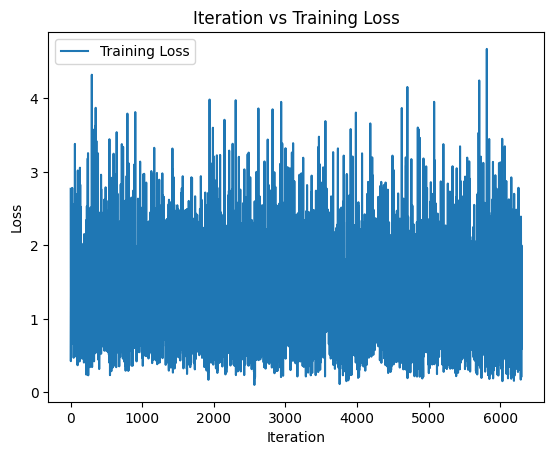

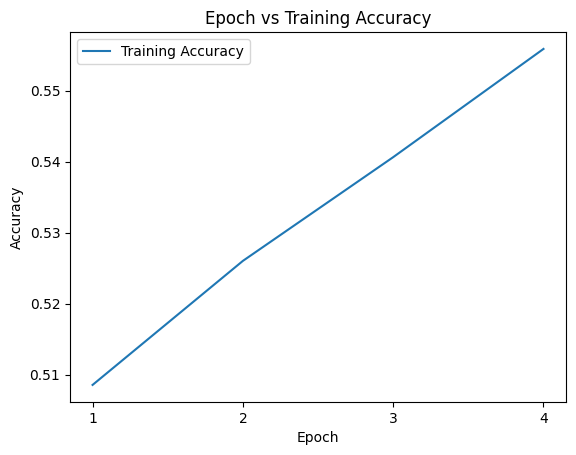

[1 2 3 4]
[0.5085714285714286, 0.5260317460317461, 0.5406349206349207, 0.5558730158730159]


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

In [33]:
from google.colab import files
files.download("mc-eiu-hubert-model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
import time
from tqdm import tqdm
from torch.utils.data import DataLoader

epoch = 4
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=False)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        with torch.no_grad():
            predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        epoch_loss.append(loss.item())

        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache()

    if epoch_i == 0 or accuracy > max(train_accuracies):
        torch.save(model.state_dict(), f"mc-eiu-hubert-model.pth")
    pbar.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/4


  0%|          | 0/1575 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Model setup and training:

In [22]:
import torch
import librosa
from datasets import Dataset
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor

In [23]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , sampling_rate=8000)  # , num_labels=num_labels)
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [24]:
def map_to_array(example):
    speech, _ = librosa.load(example["audio_file_local"], sr=1600, mono=True)
    example["speech"] = speech
    # del speech
    # gc.collect()
    return example

In [ ]:
def process_batch(batch):
    batch["input_values"] = feature_extractor(
        batch["speech"], sampling_rate=8000, padding=True, return_tensors="pt"
    )["input_values"]
    return batch

In [25]:
# class CustomDataset(Dataset):
#     def __init__(self, dataset, feature_extractor, max_length=16000):
#         self.dataset = dataset
#         self.feature_extractor = feature_extractor
#         self.max_length = max_length
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         audio_path = self.dataset.iloc[idx]["audio_file_local"]
#         speech, _ = librosa.load(audio_path, sr=8000, mono=True)

#         encodings = self.feature_extractor(
#             speech,
#             sampling_rate=8000,
#             padding="max_length",
#             max_length=self.max_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         label = torch.tensor(self.pattern.get(self.dataset.iloc[idx]["emotion_label"], -1))
#         return {"input_values": encodings["input_values"].squeeze(0), "emotion_label": label}


# class CustomDataset(Dataset):
#     def __init__(self, dataset, feature_extractor):
#         self.dataset = dataset
#         self.feature_extractor = feature_extractor
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         audio_path = self.dataset.iloc[idx]["audio_file_local"]
#         speech, _ = librosa.load(audio_path, sr=8000, mono=True)

#         encodings = self.feature_extractor(
#             speech, sampling_rate=8000, padding=True, return_tensors="pt"
#         )

#         label = torch.tensor(self.pattern.get(self.dataset.iloc[idx]["emotion_label"], -1))
#         return {"input_values": encodings["input_values"].squeeze(0), "emotion_label": label}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        self.labels = [self.pattern.get(x) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['emotion_label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
#         self.labels = [self.pattern.get(x, -1) for x in labels]

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         label = self.labels[idx]
#         if label == -1:
#             print(f"Warning: Invalid label at index {idx}")
#         item['emotion_label'] = torch.tensor(label)
#         return item

#     def __len__(self):
#         return len(self.labels)

In [ ]:
train_dataset["speech"] = train_dataset["audio_file_local"].apply(
    lambda x: librosa.load(x, sr=8000, mono=True)[0]
)

<ipython-input-16-931b65e119cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["speech"] = train_dataset["audio_file_local"].apply(


In [26]:
# train_dataset = CustomDataset(train_dataset, feature_extractor)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# for batch in train_loader:
#     print(batch["input_values"].shape, batch["emotion_label"].shape)
#     break

# train_data = Dataset.from_pandas(train_dataset)
# train_data = train_data.map(process_batch, batched=True, batch_size=16)
# train_dataset = CustomDataset(train_data["input_values"], list(train_data["emotion_label"]))

# del train_data
# gc.collect()


train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
del train_encodings, train_data
gc.collect()

Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

3

In [27]:
val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

val_dataset = CustomDataset(val_encodings, list(val_data["emotion_label"]))
del val_encodings, val_data
gc.collect()

Map:   0%|          | 0/675 [00:00<?, ? examples/s]

3

In [28]:
test_data = Dataset.from_pandas(test_dataset).map(map_to_array)
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))
del test_encodings, test_data
gc.collect()

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

20

In [30]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [32]:
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

epoch = 5
patience = 2
best_val_loss = float("inf")
early_stopping_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = []
train_accuracies = []
val_losses = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)

    model.train()
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = []

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()

        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Accuracy': f'{accuracy:.3f}'
        })

        epoch_loss.append(loss.item())
    pbar.close()

    train_loss.append(sum(epoch_loss) / len(epoch_loss))
    train_accuracies.append(accuracy)

    model.eval()
    val_loss = []
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['emotion_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    val_losses.append(avg_val_loss)

    print(f'Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "mc-eiu-hubert-model.pth")
        print("Best model saved.")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training complete.")

Epoch 1/5


  0%|          | 0/1575 [00:00<?, ?it/s]


RuntimeError: Could not infer dtype of NoneType

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

### Drafts:

In [ ]:
import io
import torch
import librosa
import torchaudio
import numpy as np
import multiprocessing
import soundfile as sf
import tensorflow as tf
from datasets import Dataset
from transformers import Wav2Vec2FeatureExtractor

def map_to_array(example):
    gcs_path = example["audio_file"]

    with tf.io.gfile.GFile(gcs_path, "rb") as f:
        audio_bytes = f.read()

    audio, samplerate = sf.read(io.BytesIO(audio_bytes), always_2d=True)

    if audio.shape[1] > 1:
        audio = audio.mean(axis=1)

    if samplerate != 16000:
        audio = librosa.resample(audio, orig_sr=samplerate, target_sr=16000)

    example["speech"] = audio
    return example

num_proc = min(multiprocessing.cpu_count() // 2, 4)
print("Number of process used:", num_proc)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array)

train_data = Dataset.from_pandas(train_dataset).map(map_to_array, keep_in_memory=False)
val_data = Dataset.from_pandas(val_dataset).map(map_to_array, keep_in_memory=False)
test_data = Dataset.from_pandas(test_dataset).map(map_to_array, keep_in_memory=False)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array, num_proc=num_proc)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array, num_proc=num_proc)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array, num_proc=num_proc)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)

Number of process used: 4


Map:   0%|          | 0/27004 [00:00<?, ? examples/s]

Map:   0%|          | 0/9001 [00:00<?, ? examples/s]

Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

In [ ]:
import torch

def encode_batch(batch, feature_extractor, device="cuda"):
    batch_size = 32
    encodings = []

    for i in range(0, len(batch), batch_size):
        batch_subset = batch[i : i + batch_size]
        encoding = feature_extractor(
            batch_subset, sampling_rate=16000, padding=True, return_tensors="pt"
        )
        encoding = {k: v.to(device) for k, v in encoding.items()}
        encodings.append(encoding)

    return encodings

num_labels = 7
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

train_encodings = encode_batch(list(train_data["speech"]), feature_extractor)
val_encodings = encode_batch(list(val_data["speech"]), feature_extractor)
test_encodings = encode_batch(list(test_data["speech"]), feature_extractor)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# num_labels=7
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)
# feature_extractor = feature_extractor.to("cuda")

# train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
# test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

num_labels = 7
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")
# train_encodings = {k: v.to("cuda") for k, v in train_encodings.items()}

val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")

test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")
# test_encodings = {k: v.to("cuda") for k, v in test_encodings.items()}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        # self.labels = [pattern[x] for x in labels]
        self.labels = [self.pattern.get(x) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['emotion_label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))

In [ ]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
from torch.utils.data import DataLoader

epoch = 5
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        epoch_loss.append(loss.item())

    torch.save(model.state_dict(), f"mc-eiu-hubert-model-{epoch_i}.pth")
    pbar.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=1.058, Accuracy=0.387]


Epoch 2/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.969, Accuracy=0.633]


Epoch 3/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.378, Accuracy=0.742]


Epoch 4/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.052, Accuracy=0.796]


Epoch 5/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.088, Accuracy=0.824]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

In [ ]:
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

epoch = 5
patience = 2
best_val_loss = float("inf")
early_stopping_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = []
train_accuracies = []
val_losses = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)

    model.train()
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = []

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()

        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Emotion_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Accuracy': f'{accuracy:.3f}'
        })

        epoch_loss.append(loss.item())
    pbar.close()

    train_loss.append(sum(epoch_loss) / len(epoch_loss))
    train_accuracies.append(accuracy)

    model.eval()
    val_loss = []
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['Emotion_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    val_losses.append(avg_val_loss)

    print(f'Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "mc-eiu-hubert-model.pth")
        print("Best model saved.")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training complete.")

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = dataset_df.drop(columns=["emotion_label"])
y = dataset_df["emotion_label"]

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanced = pd.DataFrame(X_resampled)
df_balanced["emotion_label"] = y_resampled

print("Class distribution after SMOTE:", Counter(y_resampled))

ValueError: could not convert string to float: 'gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3'

In [ ]:
local_csv_path = "/content/resampled_dataset.csv"
df.to_csv(local_csv_path, index=False)
print(f"Saved locally at: {local_csv_path}")

OUTPUT_CSV_PATH = "MC-EIU-resampled.csv"

output_blob = bucket.blob(OUTPUT_CSV_PATH)
output_blob.upload_from_filename(local_csv_path)
print(f"Uploaded to GCS: gs://{BUCKET_NAME}/{OUTPUT_CSV_PATH}")